In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBRFRegressor
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsRegressor,KNeighborsTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve,
cross_val_predict, cross_validate,permutation_test_score,validation_curve,StratifiedKFold,RandomizedSearchCV)

from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score, 
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc)

from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor,
VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor)

In [2]:
df = pd.read_csv('salary_data.csv')

In [3]:
df.head()

,YearsExperience,Salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


In [4]:
df.isna().sum()

YearsExperience    0
Salary             0
dtype: int64

In [5]:
df = df.rename(columns={'YearsExperience':'years_of_experience', 'Salary':'salary'})

In [6]:
df.head()

,years_of_experience,salary
0,1.1,39343.0
1,1.3,46205.0
2,1.5,37731.0
3,2.0,43525.0
4,2.2,39891.0


In [7]:
X = df.drop(columns=['salary'], axis=1)
y = df['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### LinearRegression

In [22]:
def basic_linear_regression():
    print("\n=== Basic Linear Regression ===")
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("Coefficients:", lin_reg.coef_)
    print("Intercept:", lin_reg.intercept_)
    
    # Visualize predictions vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.show()
    
    return lin_reg, mse, r2

In [23]:
def scaled_linear_regression():
    print("\n=== Scaled Linear Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return pipeline, mse, r2

In [24]:
# Polynomial Features
def polynomial_regression():
    print("\n=== Polynomial Regression ===")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('regression', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return pipeline, mse, r2

## Ridge

In [25]:
# Regularized Linear Regression - Ridge
def ridge_regression():
    print("\n=== Ridge Regression ===")
    param_grid = {'ridge__alpha': np.logspace(-3, 3, 7)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=42))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Best alpha: {grid_search.best_params_['ridge__alpha']}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Visualize alpha vs MSE
    plt.figure(figsize=(10, 6))
    results = pd.DataFrame(grid_search.cv_results_)
    alphas = np.array(param_grid['ridge__alpha'])
    scores = -results['mean_test_score']
    plt.semilogx(alphas, scores)
    plt.xlabel('Alpha (regularization strength)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Ridge Regression: Alpha vs MSE')
    plt.show()
    
    return best_model, mse, r2

## Lasso

In [34]:
# Regularized Linear Regression - Lasso
def lasso_regression():
    print("\n=== Lasso Regression ===")
    param_grid = {'lasso__alpha': np.logspace(-3, 1, 5)}
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', Lasso(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Best alpha: {grid_search.best_params_['lasso__alpha']}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Check which features were selected (non-zero coefficients)
    lasso_coef = best_model.named_steps['lasso'].coef_
    #selected_features = np.array(df.columns)[lasso_coef != 0]
    #print(f"Selected features: {selected_features}")
    
    # Visualize feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(df, np.abs(lasso_coef))
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Absolute Coefficient Value')
    plt.title('Lasso Regression: Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return best_model, mse, r2

## ElasticNet

In [27]:
# Elastic Net
def elastic_net_regression():
    print("\n=== Elastic Net Regression ===")
    param_grid = {
        'elasticnet__alpha': np.logspace(-3, 1, 5),
        'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('elasticnet', ElasticNet(random_state=42, max_iter=10000))
    ])
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return best_model, mse, r2

In [28]:
# Cross-validation
def cross_validation_example():
    print("\n=== Cross-Validation ===")
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('regression', LinearRegression())
    ])
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    
    print(f"Cross-Validation MSE: {mse_scores.mean():.4f} ± {mse_scores.std():.4f}")
    print(f"Cross-Validation R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
    
    return mse_scores, r2_scores

In [36]:
# Compare all models
def compare_models():
    models = {
        'Basic Linear Regression': basic_linear_regression(),
        'Scaled Linear Regression': scaled_linear_regression(),
      #  'Feature Selection (KBest)': feature_selection_kbest(),
      #  'Feature Selection (RFE)': feature_selection_rfe(),
        'Polynomial Regression': polynomial_regression(),
        'Ridge Regression': ridge_regression(),
      #  'Lasso Regression': lasso_regression(),
        'Elastic Net': elastic_net_regression()
    }
    
    # Extract MSE and R² scores
    results = {name: {'MSE': mse, 'R²': r2} for name, (_, mse, r2) in models.items()}
    results_df = pd.DataFrame(results).T
    
    # Sort by MSE (lower is better)
    results_df = results_df.sort_values('MSE')
    
    print("\n=== Model Comparison ===")
    print(results_df)
    
    # Plot comparison
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 1, 1)
    plt.bar(results_df.index, results_df['MSE'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('Model Comparison - MSE (lower is better)')
    
    plt.subplot(2, 1, 2)
    plt.bar(results_df.index, results_df['R²'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('R² Score (higher is better)')
    plt.title('Model Comparison - R² (higher is better)')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

In [30]:
# Feature Correlation Analysis
def feature_correlation_analysis():
    print("\n=== Feature Correlation Analysis ===")
    X_df = pd.DataFrame(df, columns=df.columns)
    
    corr = X_df.corr()
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    # Sort features by correlation with target
    #target_corr = corr['target'].sort_values(ascending=False)
    #print("Feature correlation with target (house price):")

    return corr

=== Linear Regression Tuning Examples ===

=== Feature Correlation Analysis ===


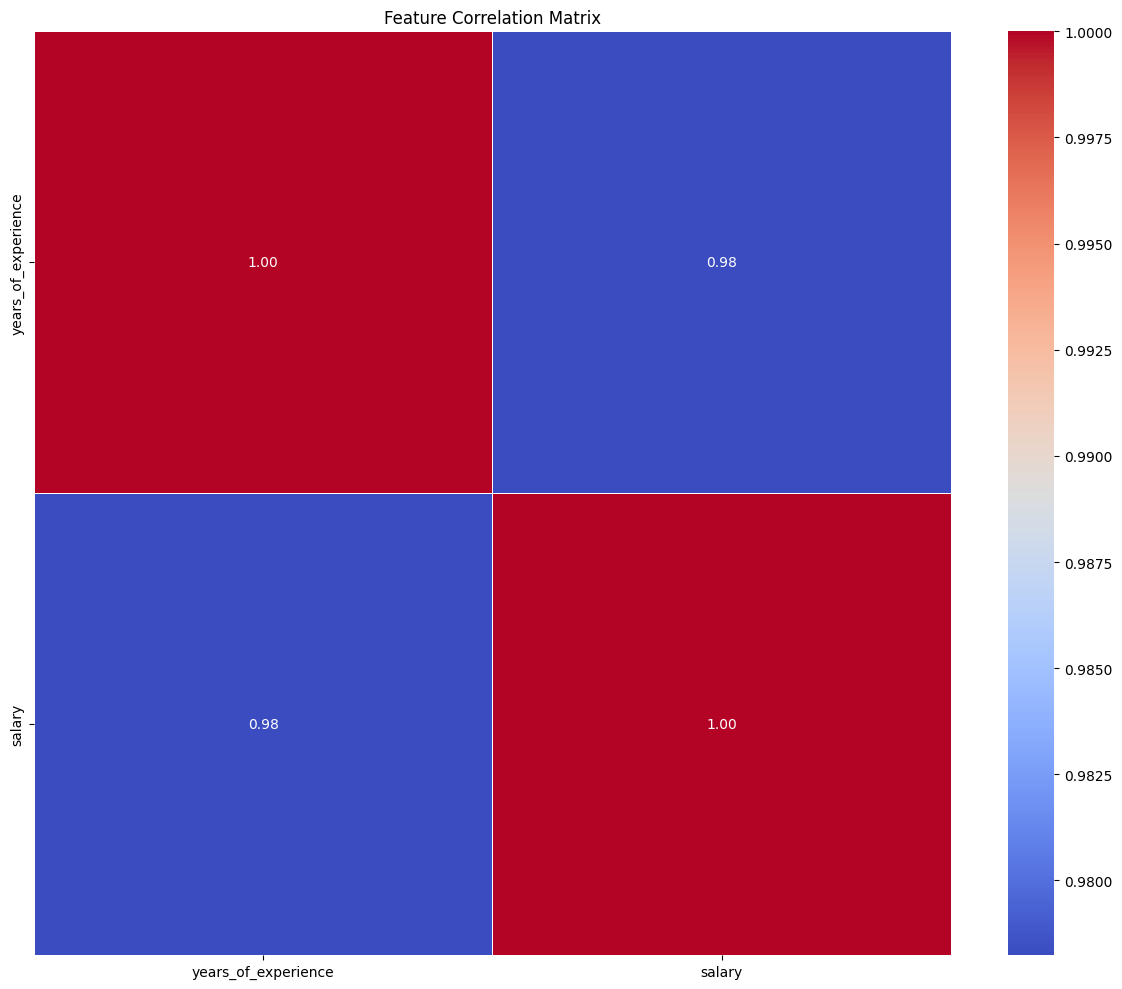


=== Cross-Validation ===
Cross-Validation MSE: 33775677.2249 ± 12091674.1954
Cross-Validation R²: 0.9224 ± 0.0496

=== Basic Linear Regression ===
Mean Squared Error: 49830096.8559
R² Score: 0.9024
Coefficients: [9423.81532303]
Intercept: 25321.583011776813


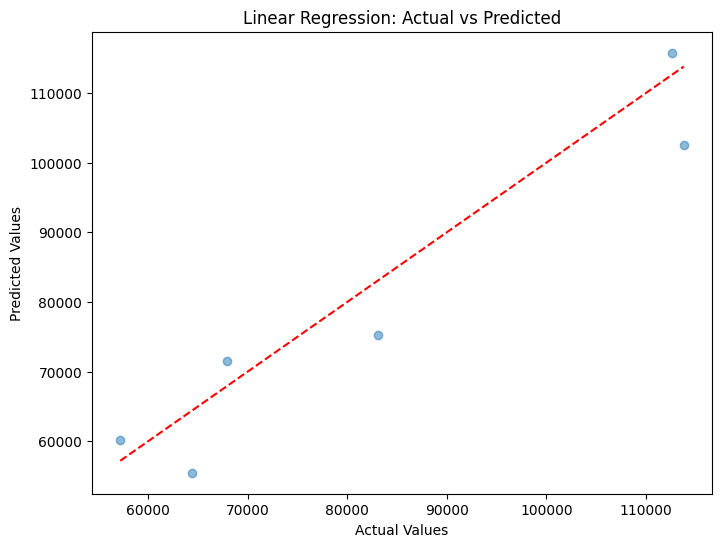


=== Scaled Linear Regression ===
Mean Squared Error: 49830096.8559
R² Score: 0.9024

=== Polynomial Regression ===
Mean Squared Error: 52527916.3688
R² Score: 0.8972

=== Ridge Regression ===
Best alpha: 0.1
Mean Squared Error: 49948555.9660
R² Score: 0.9022


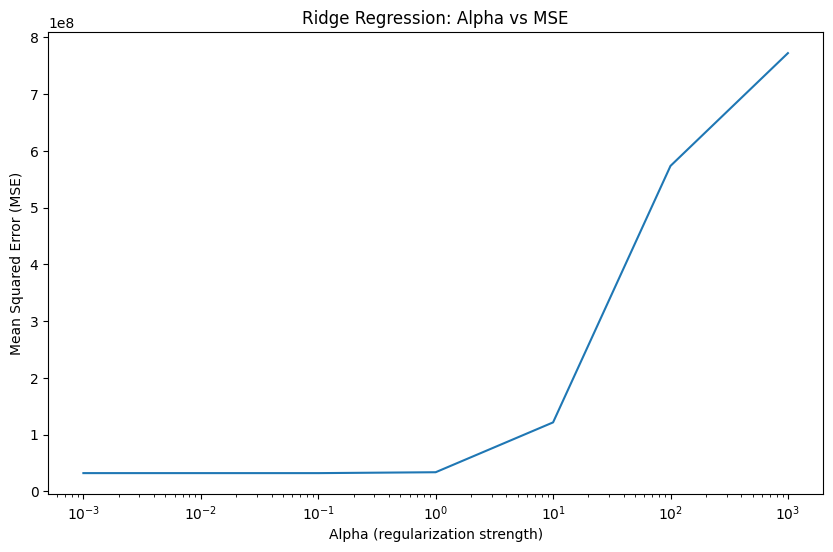


=== Elastic Net Regression ===
Best parameters: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5}
Mean Squared Error: 49974251.9873
R² Score: 0.9022

=== Model Comparison ===
                                   MSE        R²
Scaled Linear Regression  4.983010e+07  0.902446
Basic Linear Regression   4.983010e+07  0.902446
Ridge Regression          4.994856e+07  0.902214
Elastic Net               4.997425e+07  0.902164
Polynomial Regression     5.252792e+07  0.897165


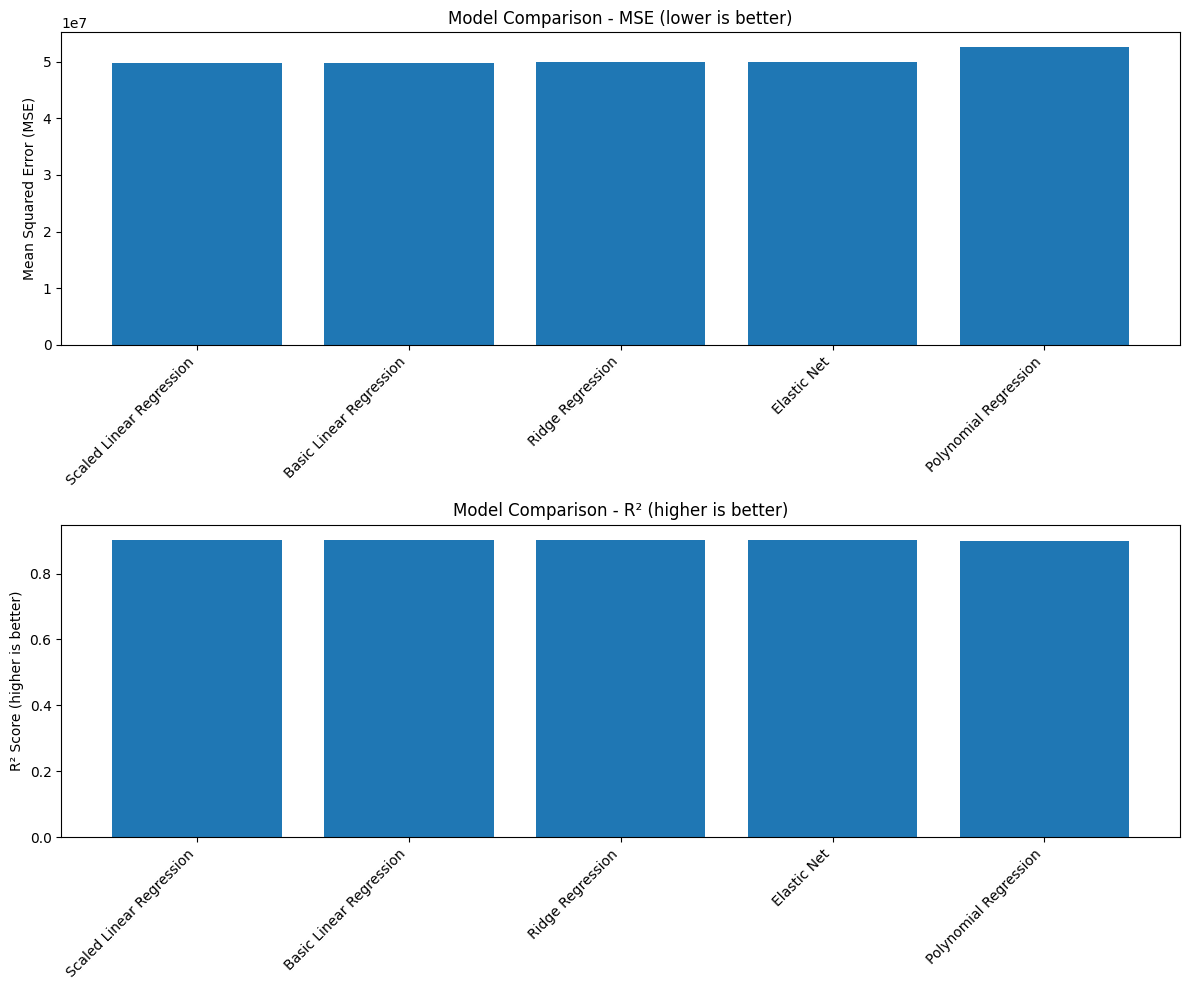


Best model according to MSE: Scaled Linear Regression


In [37]:
# Main execution
if __name__ == "__main__":
    print("=== Linear Regression Tuning Examples ===")
    feature_correlation_analysis()
    cross_validation_example()
    results = compare_models()
    
    print("\nBest model according to MSE:", results.index[0])